In [1]:
import pandas as pd
import numpy as np
import gpflow
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
crashes = pd.read_csv('gp_grid_parkslope.csv')

n = len(crashes)
crashes.drop(crashes.columns[0], inplace = True, axis = 1)
crashes.sort_values(['DATE_IND', 'GRID_SQUARE'], inplace = True)
crashes['x_point'] = crashes['x_point'] / 100000  #+ np.random.normal(0,.001, size= n)
crashes['y_point'] = crashes['y_point'] / 100000  #+ np.random.normal(0,.001, size = n)

crashes['x_norm'] = (crashes['x_point'] - crashes['x_point'].mean()) / crashes['x_point'].std()
crashes['y_norm'] = (crashes['y_point'] - crashes['y_point'].mean()) / crashes['y_point'].std()


crashes['GRID_SQUARE'] = crashes['GRID_SQUARE'].astype(np.float32)
crashes['DATE_IND'] = crashes['DATE_IND'].astype(np.float32)

crashes.head()

,DATETIME,GRID_SQUARE,COUNT,x_point,y_point,DATE_IND,x_norm,y_norm
0,2013-05-31,1.0,0.0,9.855685,1.88006,1.0,-1.463592,1.527256
59,2013-05-31,2.0,0.0,9.855685,1.86756,1.0,-1.463592,1.090897
118,2013-05-31,3.0,0.0,9.855685,1.85506,1.0,-1.463592,0.654538
177,2013-05-31,4.0,1.0,9.855685,1.84256,1.0,-1.463592,0.218179
236,2013-05-31,5.0,1.0,9.855685,1.83006,1.0,-1.463592,-0.218179


In [3]:
dat = crashes[(crashes.DATE_IND > 20) & (crashes.DATE_IND < 49)]

X = np.vstack([dat.DATE_IND.values.ravel(), dat.x_point.ravel(), dat.y_point.ravel()]).T
y = dat.COUNT.values.reshape((len(dat),1))


In [4]:
use_priors = True

with gpflow.defer_build():

    like = gpflow.likelihoods.Poisson()
    kern_s_effect = gpflow.kernels.RBF(2, active_dims=[1,2], name='space_effect')
    kern_t_effect = gpflow.kernels.RBF(1, active_dims=[0], name='time_effect')

    ## Will have to write custom kernel to match Flaxman 2014
    kern_p_effect = gpflow.kernels.Periodic(1, active_dims=[0], name = 'periodic_effect')
    kern_st_effect = gpflow.kernels.Product([kern_s_effect ,kern_t_effect])

    full_kern =  kern_t_effect + kern_s_effect + kern_p_effect + kern_st_effect
    
    m = gpflow.models.VGP(X, y, full_kern,  likelihood = like)
    
    m.kern.periodic.period = 12
    m.kern.periodic.period.trainable = False
    
    normal_prior = gpflow.priors.Gaussian(mu = 0 , var = 1)
    if use_priors:
        m.kern.rbf_1.variance.prior    = normal_prior
        m.kern.periodic.variance.prior = normal_prior
        m.kern.rbf_2.variance.prior    = normal_prior
        
        m.kern.rbf_1.lengthscales.prior = normal_prior
        m.kern.rbf_2.lengthscales.prior = normal_prior
        m.kern.periodic.lengthscales.prior = normal_prior


m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
VGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 1344, 1344)",True,"[[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
VGP/kern/rbf_2/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.0
VGP/kern/rbf_2/lengthscales,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.0
VGP/kern/rbf_1/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.0
VGP/kern/rbf_1/lengthscales,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.0
VGP/kern/rbf_1/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.0
VGP/kern/rbf_1/lengthscales,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.0
VGP/kern/rbf_2/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.0
VGP/kern/rbf_2/lengthscales,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.0
VGP/kern/periodic/period,Parameter,None,+ve,False,(),True,12.0


In [5]:
m.compile()
opt = gpflow.train.ScipyOptimizer()

In [6]:
m.compute_log_likelihood()

-12876.256151780313

In [7]:
#opt.minimize(m, maxiter = 1000)

In [8]:
#opt.minimize(m, maxiter= 500)

custom_config = gpflow.settings.get_settings()
custom_config.numerics.jitter_level = 1e-6

with gpflow.settings.temp_settings(custom_config):
     opt.minimize(m, maxiter=1000)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1864.471692
  Number of iterations: 984
  Number of functions evaluations: 1065


In [9]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
VGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 1344, 1344)",True,"[[[0.556979104082, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
VGP/kern/rbf_2/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.3158602269513189
VGP/kern/rbf_2/lengthscales,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,0.011735110899317433
VGP/kern/rbf_1/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,0.1003544123267372
VGP/kern/rbf_1/lengthscales,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,0.8403051655344297
VGP/kern/rbf_1/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,0.1003544123267372
VGP/kern/rbf_1/lengthscales,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,0.8403051655344297
VGP/kern/rbf_2/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.3158602269513189
VGP/kern/rbf_2/lengthscales,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,0.011735110899317433
VGP/kern/periodic/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,0.7881880326578797


In [10]:
dat = crashes

X = np.vstack([dat.DATE_IND.values.ravel(), dat.x_point, dat.y_point]).T
y = dat.COUNT.values.reshape((len(dat),1))

pred_mean, pred_variance = m.predict_y(X)


In [11]:
dat['pred'] = pred_mean


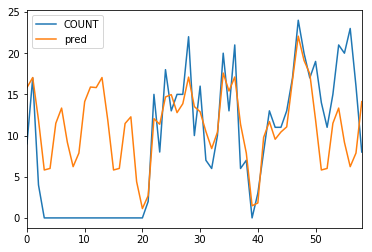

In [12]:
dat[dat.GRID_SQUARE == 33 ].reset_index()[['COUNT', 'pred']].plot()

In [13]:
predicted = crashes[crashes.DATE_IND > 48].copy()

np.sqrt(np.square(predicted.pred - predicted.COUNT).sum())

49.60184174711123

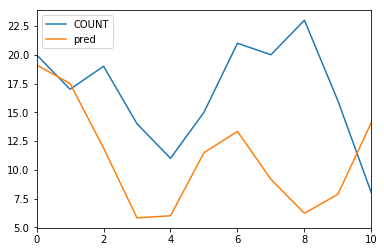

In [14]:
predicted[predicted.GRID_SQUARE == 33 ].reset_index()[['COUNT', 'pred']].plot()